In [8]:
# Smarter Circuits #
import sys
sys.path.append('../')


import imagePreprocessing as ip
import graphGeneration as gg
import componentClassification as cc
import matplotlib.pyplot as plt
import cv2
import lib.utils as utils
import random
import string

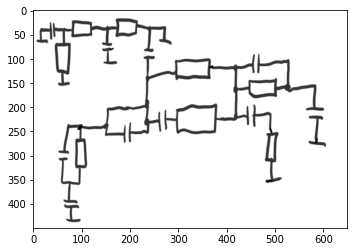

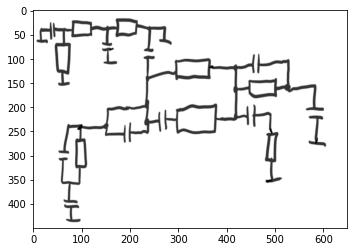

In [9]:
name = "4.png"

image = utils.loadImage(path="./../resources/testImages",name=name)

colorImage = utils.loadImage(path="./../resources/testImages",name=name, color=True)

plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(colorImage)

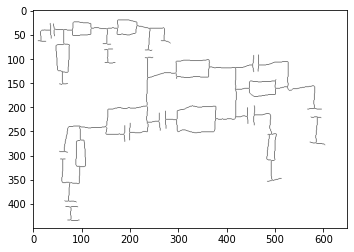

In [10]:
preprocessedImage = ip.preprocessImage(image)
utils.saveImage(name="preprocessed.png", image=preprocessedImage)

plt.imshow(preprocessedImage, cmap='gray')

In [11]:
def generateTrainData(boundingBoxes, image):
    components = []
    for box in boundingBoxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        component = cv2.resize(component, (32,32), interpolation = cv2.INTER_AREA)
        utils.saveImage(name="{i}.png".format(i=''.join(random.choice(string.ascii_lowercase) for i in range(10))), image=component)

In [12]:
boundingBoxes = gg.generateBoudingBoxes(preprocessedImage)

#generateTrainData(boundingBoxes, image)
print(len(boundingBoxes))

end reached
22


In [13]:
predictions = cc.classify(boundingBoxes, image)

print(predictions)

['capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'ground', 'ground', 'ground', 'ground', 'ground', 'ground', 'ground']


inductor -> blue
resistor -> green
capacitor -> red
ground -> purple


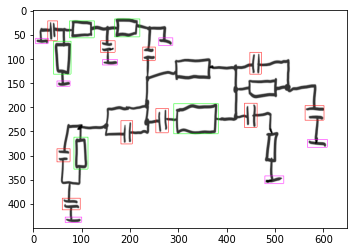

In [14]:
for i in range(0, len(boundingBoxes)):
    if predictions[i] == "inductor":
        utils.drawRect(colorImage,boundingBoxes[i],(255,0,0))
    elif predictions[i] == "resistor":
        utils.drawRect(colorImage,boundingBoxes[i],(0,255,0))
    elif predictions[i] == "capacitor":
        utils.drawRect(colorImage,boundingBoxes[i],(0,0,255))
    elif predictions[i] == "ground":
        utils.drawRect(colorImage,boundingBoxes[i],(255,0,255))
        
    
print("inductor -> blue")
print("resistor -> green")
print("capacitor -> red")
print("ground -> purple")


utils.saveImage(name="boundingBoxes.png", image=colorImage, color=True)
colorImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage)